# MAGCOM算法仿真实验

# 依赖包

In [93]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from copy import deepcopy
import random

# 模版匹配类定义

## MAGCOM

In [90]:
class MAGCOMTerrainMatcher:
    """
    MA-GCOM (Moving Average - Generalized Correlation Matching) based terrain matching algorithm.
    This class implements a simplified MA-GCOM approach for matching measured terrain profile with a reference map.
    """

    def __init__(self, reference_map: np.ndarray, window_size: int = 10):
        """
        :param reference_map: 2D numpy array representing the reference terrain map (e.g., from DEM).
        :param window_size: Size of the matching window (sliding window) used in the algorithm.
        """
        self.reference_map = reference_map
        self.window_size = window_size

    def moving_average(self, data: np.ndarray) -> np.ndarray:
        """Applies a 2D moving average to smooth the data."""
        return gaussian_filter(data, sigma=1)

    def match(self, measured_profile: np.ndarray) -> tuple:
        """
        Match the measured profile against the reference map using generalized correlation.
        :param measured_profile: 2D terrain profile measured (e.g., by multi-beam).
        :return: Best match coordinates (x, y) in the reference map.
        """
        ref_map_smoothed = self.moving_average(self.reference_map)
        profile_smoothed = self.moving_average(measured_profile)

        h, w = profile_smoothed.shape
        H, W = ref_map_smoothed.shape

        best_score = -np.inf
        best_coords = (0, 0)

        for i in range(H - h):
            for j in range(W - w):
                window = ref_map_smoothed[i:i + h, j:j + w]
                score = self.generalized_correlation(window, profile_smoothed)
                if score > best_score:
                    best_score = score
                    best_coords = (i, j)

        return best_coords

    @staticmethod
    def generalized_correlation(a: np.ndarray, b: np.ndarray) -> float:
        """Computes normalized cross-correlation between two 2D arrays."""
        a_mean = a - np.mean(a)
        b_mean = b - np.mean(b)
        numerator = np.sum(a_mean * b_mean)
        denominator = np.sqrt(np.sum(a_mean ** 2) * np.sum(b_mean ** 2))
        return numerator / denominator if denominator != 0 else 0
    

class TrajectoryBasedTerrainMatcher(MAGCOMTerrainMatcher):
    """
    在基础模版匹配类的基础上定义子类，用于实现载体轨迹模版匹配算法。
    """
    
    def __init__(self, reference_map: np.ndarray, window_length: int = 10, resolution: float = 1.0):
        super().__init__(reference_map, window_size=window_length)
        self.window_length = window_length
        self.resolution = resolution
        
    
    def gen_multi_trajectory_patch(self, x: int, y: int, heading: int, mode: int) -> np.ndarray:
        """生成不同类型的样例轨迹
        :param mode: 不同类型的生成方法,1代表普通的直线生成,2代表随机的折线生成
        """
        profile, x_pos_list, y_pos_list = [], [], []
        if mode == 1:
            rad = np.deg2rad(heading)
            dx = np.cos(rad)
            dy = -np.sin(rad)
            
            for i in range(self.window_length):
                xi = int(round(x + i * dx))
                yi = int(round(y + i * dy))
                if 0 <= xi < self.reference_map.shape[0] and 0 <= yi < self.reference_map.shape[1]:
                    profile.append(self.reference_map[xi, yi])
                    x_pos_list.append(xi)
                    y_pos_list.append(yi)
                else:
                    profile.append(np.nan)
                    x_pos_list.append(np.nan)
                    y_pos_list.append(np.nan)
        elif mode == 2:
            k = 4
            for epoch in range(k):
                rad = np.deg2rad(heading)+random.random()*3.14
                dx = np.cos(rad)
                dy = -np.sin(rad)
                for i in range(self.window_length//k):
                    xi = int(round(x + i * dx))
                    yi = int(round(y + i * dy))
                    if 0 <= xi < self.reference_map.shape[0] and 0 <= yi < self.reference_map.shape[1]:
                        profile.append(self.reference_map[xi, yi])
                        x_pos_list.append(xi)
                        y_pos_list.append(yi)
                    else:
                        profile.append(np.nan)
                        x_pos_list.append(np.nan)
                        y_pos_list.append(np.nan) 
                x = xi
                y = yi
            
        else:
            print("Generating Trajectory Patch Failed, please check the mode index.")
            return 
        
        profile_with_pos = np.array([x_pos_list, y_pos_list, profile])
        
        return profile_with_pos if not np.any(np.isnan(profile_with_pos)) else None

    def extract_trajectory_patch(self, x: int, y: int, heading: float) -> np.ndarray:
        """通过航向确定轨迹"""
        rad = np.deg2rad(heading)
        dx = np.cos(rad)
        dy = -np.sin(rad)

        profile = []
        x_pos_list, y_pos_list = [], []
        for i in range(self.window_length):
            xi = int(round(x + i * dx))
            yi = int(round(y + i * dy))
            if 0 <= xi < self.reference_map.shape[0] and 0 <= yi < self.reference_map.shape[1]:
                profile.append(self.reference_map[xi, yi])
                x_pos_list.append(xi)
                y_pos_list.append(yi)
            else:
                profile.append(np.nan)
                x_pos_list.append(np.nan)
                y_pos_list.append(np.nan)

        profile_with_pos = np.array([x_pos_list, y_pos_list, profile])
        
        return profile_with_pos if not np.any(np.isnan(profile_with_pos)) else None
    
    def extract_trajectory_patch2(self, x, y, true_profile) -> np.ndarray:
        """参考样例位置序列确定待匹配序列的轨迹
        :param x&y:起始位置的x,y坐标
        :param true_profile: 样例数据, shape=(3, N),前两维指示x,y坐标序列,最后一维指示地形信息
        :return: 
        """
        delta_x = [i-true_profile[0, 0] for i in true_profile[0, :]]
        delta_y = [i-true_profile[1, 0] for i in true_profile[1, :]]

        profile = []
        x_pos_list, y_pos_list = [], []
        for i in range(self.window_length):
            xi = int(round(x + delta_x[i]))
            yi = int(round(y + delta_y[i]))
            if 0 <= xi < self.reference_map.shape[0] and 0 <= yi < self.reference_map.shape[1]:
                profile.append(self.reference_map[xi, yi])
                x_pos_list.append(xi)
                y_pos_list.append(yi)
            else:
                profile.append(np.nan)
                x_pos_list.append(np.nan)
                y_pos_list.append(np.nan)

        profile_with_pos = np.array([x_pos_list, y_pos_list, profile])
        
        return profile_with_pos if not np.any(np.isnan(profile_with_pos)) else None

    def match_trajectory(self, measured_profile: np.ndarray, heading: float, gen_mode: int) -> tuple:
        """轨迹匹配
        :param gen_mode:代表生成待匹配轨迹方式,1表示通过航向确定,2表示参考样例位置序列确定
        """
        best_score = -np.inf
        best_candidate = None

        for x in range(self.reference_map.shape[0]):
            for y in range(self.reference_map.shape[1]):
                # 获取待匹配轨迹序列
                if gen_mode == 1:
                    candidate = self.extract_trajectory_patch(x, y, heading)
                elif gen_mode == 2:
                    candidate = self.extract_trajectory_patch2(x, y, measured_profile)
                else:
                    candidate = self.extract_trajectory_patch(x, y, heading)
                    
                if candidate is not None and len(candidate[2, :]) == len(measured_profile[2, :]):
                    score = self.generalized_correlation(candidate[2, :].reshape(1, -1),
                                                        measured_profile[2, :].reshape(1, -1))
                    if score > best_score:
                        best_score = score
                        best_candidate = candidate

        return best_candidate


## ICCP算法

In [ ]:
import numpy as np

def iccp_algorithm(real_points, contour_map, initial_guess, max_iter=100, tol=1e-3):
    """
    ICCP算法实现
    算法思路：实时捕获的位置和高程序列与基准图网格中对应位置的高程序列有偏差,ICCP认为这种偏差是由于
    实时捕获的位置序列存在偏差导致的，所以要以高程序列为准，修正实时捕获的位置序列。
    
    参数:
        real_points (np.array): 实时测量点集，形状为(n, 3)，每行[x, y, z]
        contour_map (np.array): 基准图网格，形状为(h, w)，每个元素为重力值或高程
        initial_guess (np.array): 初始平移估计 [Δx, Δy]
        max_iter (int): 最大迭代次数
        tol (float): 收敛阈值
    
    返回:
        np.array: 最优平移量 [Δx, Δy]
    """
    current_transform = initial_guess.copy()
    h, w = contour_map.shape
    
    for iter in range(max_iter):
        # 1. 投影实时点到基准图坐标系
        projected_points = real_points[:, :2] + current_transform
        residuals = []
        
        # 2. 寻找最近等高线点
        matched_points = []
        for (x, y, z) in real_points:
            # 投影后的坐标
            x_proj, y_proj = x + current_transform[0], y + current_transform[1]
            
            # 在基准图上寻找与z值相等的等高线点（简化示例，实际需插值）
            # 此处简化为寻找基准图中与z最接近的等高线点
            dist = np.abs(contour_map - z)
            y_idx, x_idx = np.unravel_index(np.argmin(dist), contour_map.shape)
            q = np.array([x_idx, y_idx])  # 转换为实际坐标需根据网格分辨率缩放
            
            matched_points.append(q)
        
        matched_points = np.array(matched_points)
        
        # 3. 计算平移量
        delta = np.mean(matched_points - projected_points[:, :2], axis=0)
        print(current_transform)
        
        # 4. 更新变换
        current_transform += delta
        
        # 5. 检查收敛
        if np.linalg.norm(delta) < tol:
            break
    
    return current_transform

# 示例使用
if __name__ == "__main__":
    # 生成模拟数据
    real_points = np.array([
        [10, 20, 50],
        [15, 25, 50],
        [20, 30, 50]
    ])  # 假设z=50为等高线值
    
    # 基准图（假设为50x50网格，目标等高线在(30,40)附近）
    contour_map = np.zeros((50, 50))
    contour_map[35:45, 25:35] = 50  # 设置等高线区域
    
    # 初始猜测为[0,0]
    initial_guess = np.array([0.0, 0.0])
    
    # 运行ICCP
    result = iccp_algorithm(real_points, contour_map, initial_guess)
    print("最优平移量:", result)

In [ ]:
class TrajectoryMatcherBasedICCP(TrajectoryBasedTerrainMatcher):
    """
    在MAGCOM模版匹配类的基础上定义ICCP类，用于实现ICCP算法。
    """
    
    def __init__(self, reference_map: np.ndarray, window_length: int = 10, resolution: float = 1.0):
        super().__init__(reference_map, window_length=window_length, resolution=resolution)

    def iccp(self, measured_profile: np.ndarray, heading: float, gen_mode: int) -> tuple:
        """轨迹匹配
        :param gen_mode:代表生成待匹配轨迹方式,1表示通过航向确定,2表示参考样例位置序列确定
        """
        best_score = -np.inf
        best_candidate = None

        for x in range(self.reference_map.shape[0]):
            for y in range(self.reference_map.shape[1]):
                # 获取待匹配轨迹序列
                if gen_mode == 1:
                    candidate = self.extract_trajectory_patch(x, y, heading)
                elif gen_mode == 2:
                    candidate = self.extract_trajectory_patch2(x, y, measured_profile)
                else:
                    candidate = self.extract_trajectory_patch(x, y, heading)
                    
                if candidate is not None and len(candidate[2, :]) == len(measured_profile[2, :]):
                    score = self.generalized_correlation(candidate[2, :].reshape(1, -1),
                                                        measured_profile[2, :].reshape(1, -1))
                    if score > best_score:
                        best_score = score
                        best_candidate = candidate

        return best_candidate


[[ 8.20561845e-07 -3.55922240e-07]
 [ 1.45607032e-06 -6.04602671e-07]
 [ 2.05118098e-06 -7.58765004e-07]
 [ 2.54088562e-06 -7.71539075e-07]
 [ 2.82376885e-06 -6.05740126e-07]
 [ 2.96450503e-06 -2.86263115e-07]
 [ 2.94972904e-06  1.63128781e-07]
 [ 2.54419524e-06  6.32740219e-07]
 [ 2.06991846e-06  1.03869354e-06]
 [ 1.60336526e-06  1.40300419e-06]
 [ 9.10430354e-07  1.45538056e-06]
 [ 2.69430181e-07  1.32787805e-06]
 [-2.31743540e-07  9.25796685e-07]
 [-4.19076681e-07  5.03352264e-07]
 [-2.68830846e-07  1.74129948e-07]
 [ 4.84697464e-09  3.06686844e-08]
 [ 3.54465927e-07 -3.58668948e-09]
 [ 7.09942367e-07  3.13191174e-08]
 [ 1.23716040e-06  1.26035148e-07]
 [ 1.49704606e-06  2.07688341e-07]
 [ 1.29200250e-06  1.98632220e-07]
 [ 9.55638055e-07  1.40782196e-07]
 [ 5.55111347e-07  5.77972863e-08]
 [ 2.03128099e-07 -2.82617426e-09]
 [ 5.71041248e-08 -1.61354466e-08]
 [ 2.21656796e-08 -1.68127557e-08]
 [-4.71617511e-09  1.51643760e-08]
 [-2.16600556e-09  1.44781568e-08]
 [ 3.78702891e-08 -5

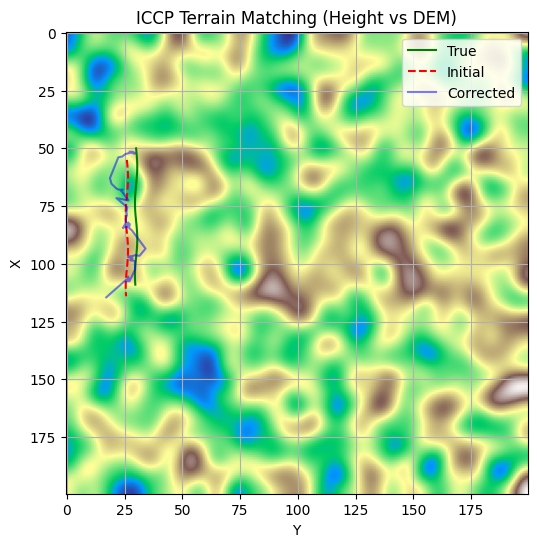

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

class ICCPOptimizer:
    def __init__(self, dem_map, step_size=0.1, max_iters=100):
        self.dem_map = dem_map
        self.step_size = step_size
        self.max_iters = max_iters
        self.map_height, self.map_width = dem_map.shape

    def extract_altitude(self, trajectory):
        altitudes = []
        for x, y in trajectory:
            xi, yi = int(round(x)), int(round(y))
            if 0 <= xi < self.map_height and 0 <= yi < self.map_width:
                altitudes.append(self.dem_map[xi, yi])
            else:
                altitudes.append(np.nan)
        return np.array(altitudes)

    def compute_loss(self, measured, estimated):
        valid = ~np.isnan(estimated)
        return np.mean((measured[valid] - estimated[valid]) ** 2)

    def optimize_trajectory(self, init_traj, measured_alt):
        traj = init_traj.copy()
        for _ in range(self.max_iters):
            grad = np.zeros_like(traj)
            base_loss = self.compute_loss(measured_alt, self.extract_altitude(traj))
            # print(base_loss)
            # eps = 1e-3
            eps = 1

            for i in range(len(traj)):
                for j in range(2):  # x, y
                    perturbed = traj.copy()
                    perturbed[i, j] += eps
                    loss_perturbed = self.compute_loss(measured_alt, self.extract_altitude(perturbed))

                    # print(loss_perturbed, base_loss)

                    grad[i, j] = (loss_perturbed - base_loss) / eps

            
            print(grad)

            traj -= self.step_size * grad

        return traj

# ---------- 仿真数据生成 ----------
np.random.seed(42)
dem = gaussian_filter(np.random.rand(200, 200), sigma=5)
true_traj = np.array([[50 + i, 30 + 0.5 * np.sin(i / 5)] for i in range(60)])

def sample_dem(traj, dem):
    alt = []
    for x, y in traj:
        xi, yi = int(round(x)), int(round(y))
        alt.append(dem[xi, yi] if 0 <= xi < dem.shape[0] and 0 <= yi < dem.shape[1] else np.nan)
    return np.array(alt)

measured_alt = sample_dem(true_traj, dem) + np.random.normal(0, 0.001, len(true_traj))
init_traj = true_traj + np.array([5.0, -4.0])

# ---------- 执行 ICCP 匹配 ----------
optimizer = ICCPOptimizer(dem, step_size=10**5, max_iters=500)
corrected_traj = optimizer.optimize_trajectory(init_traj, measured_alt)

# ---------- 可视化 ----------
plt.figure(figsize=(8, 6))
plt.imshow(dem, cmap='terrain')
plt.plot(true_traj[:, 1], true_traj[:, 0], 'g-', label='True')
plt.plot(init_traj[:, 1], init_traj[:, 0], 'r--', label='Initial')
plt.plot(corrected_traj[:, 1], corrected_traj[:, 0], 'b-', label='Corrected', alpha=0.5)
plt.legend()
plt.title("ICCP Terrain Matching (Height vs DEM)")
plt.xlabel("Y")
plt.ylabel("X")
plt.grid(True)
plt.show()


# 评估函数

In [11]:
def compute_rmse(true_coords, estimated_coords):
    """
    Computes RMSE between true and estimated coordinates.
    :param true_coords: Tuple (x, y) of the ground truth location.
    :param estimated_coords: Tuple (x, y) of the matched location.
    :return: RMSE value.
    """
    true = np.array(true_coords)
    estimated = np.array(estimated_coords)
    return np.sqrt(np.mean((true - estimated) ** 2))

def compute_mismatch_probability(reference_map, profile, true_coords, matcher, threshold=5):
    """
    Estimates the probability of mismatch by testing multiple noisy profiles.
    :param reference_map: The reference terrain map.
    :param profile: Original measured profile without noise.
    :param true_coords: Ground truth (x, y).
    :param matcher: An instance of the MAGCOMTerrainMatcher.
    :param threshold: Distance threshold beyond which a match is considered incorrect.
    :return: Mismatch rate.
    """
    num_trials = 50
    mismatches = 0

    for _ in range(num_trials):
        noisy_profile = profile + np.random.normal(0, 0.02, profile.shape)
        estimated_coords = matcher.match(noisy_profile)
        error = compute_rmse(true_coords, estimated_coords)
        if error > threshold:
            mismatches += 1

    return mismatches / num_trials


# 工具函数

# Demo

## 测试2D匹配

In [12]:
# Simulate a terrain map and measured terrain profile
np.random.seed(0)
terrain_map = gaussian_filter(np.random.rand(100, 100), sigma=3)
measured_x, measured_y = 40, 60
measured_profile = terrain_map[measured_x:measured_x + 10, measured_y:measured_y + 10] + np.random.normal(0, 0.01, (10, 10))

# Run MA-GCOM terrain matching
matcher = MAGCOMTerrainMatcher(reference_map=terrain_map, window_size=10)
matched_coords = matcher.match(measured_profile)

# Evaluate RMSE
rmse = compute_rmse((measured_x, measured_y), matched_coords)
print(f"RMSE between true and matched location: {rmse:.2f} pixels")

# Evaluate mismatch probability
mismatch_rate = compute_mismatch_probability(terrain_map, measured_profile, (measured_x, measured_y), matcher)
print(f"Estimated mismatch probability (error > 5 pixels): {mismatch_rate:.2%}")

NameError: name 'MAGCOMTerrainMatcher' is not defined

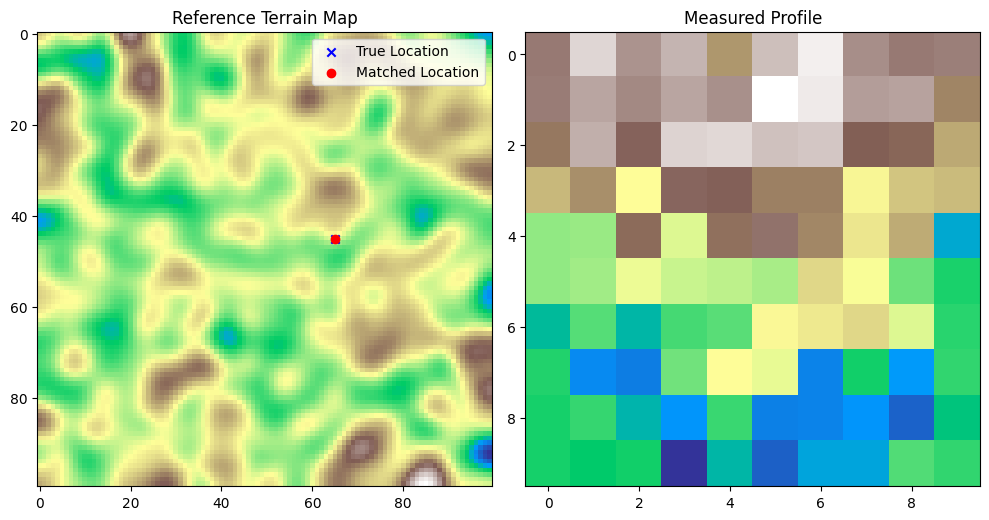

In [6]:
# Visualization
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Reference Terrain Map")
plt.imshow(terrain_map, cmap='terrain')
plt.scatter(measured_y + 5, measured_x + 5, marker='x', color='blue', label='True Location')
plt.scatter(matched_coords[1] + 5, matched_coords[0] + 5, marker='o', color='red', label='Matched Location')
plt.legend()

plt.subplot(1, 2, 2)
plt.title("Measured Profile")
plt.imshow(measured_profile, cmap='terrain')

plt.tight_layout()
plt.show()


## 测试轨迹匹配

### 用法一: 假定航向不变

In [98]:
# Simulate terrain map and trajectory-based profile
np.random.seed(42)
terrain_map = gaussian_filter(np.random.rand(100, 100), sigma=3)
true_start_x, true_start_y = 30, 70
true_heading = 45
trajectory_length = 20

matcher_traj = TrajectoryBasedTerrainMatcher(reference_map=terrain_map, window_length=trajectory_length)
true_profile = matcher_traj.extract_trajectory_patch(true_start_x, true_start_y, true_heading)

measured_profile = deepcopy(true_profile)
measured_profile[2, :] = measured_profile[2, :] + np.random.normal(0, 0.01, measured_profile.shape[1])
estimated_coords = matcher_traj.match_trajectory(measured_profile, true_heading, gen_mode=1)

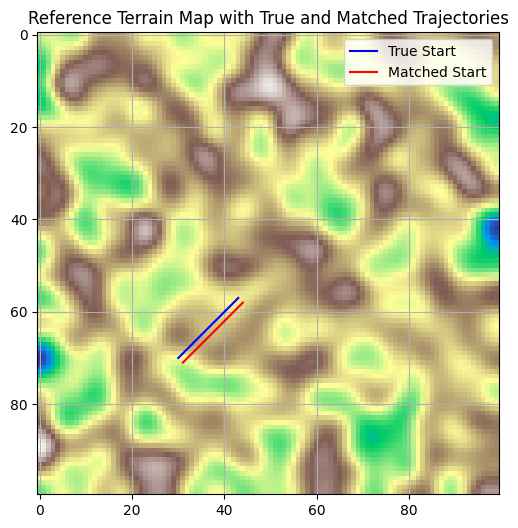

In [69]:
# Visualization
plt.figure(figsize=(6, 6))
plt.title("Reference Terrain Map with True and Matched Trajectories")
plt.imshow(terrain_map, cmap='terrain')
plt.plot(true_profile[0, :], true_profile[1, :], color='blue', label='True Start')
plt.plot(estimated_coords[0, :], estimated_coords[1, :], color='red', label='Matched Start')
plt.legend()
plt.grid(True)
plt.show()

# Evaluation
# rmse_traj = compute_rmse((true_start_x, true_start_y), estimated_coords)
# print(f"Trajectory Matching RMSE: {rmse_traj:.2f} pixels")


In [66]:
# Simulate terrain map and trajectory-based profile
np.random.seed(42)
terrain_map = gaussian_filter(np.random.rand(100, 100), sigma=3)
true_start_x, true_start_y = 30, 70
true_heading = 45
trajectory_length = 20

matcher_traj = TrajectoryBasedTerrainMatcher(reference_map=terrain_map, window_length=trajectory_length)
true_profile = matcher_traj.extract_trajectory_patch(true_start_x, true_start_y, true_heading)

# 用法二:
measured_profile = deepcopy(true_profile)
measured_profile[2, :] = measured_profile[2, :] + np.random.normal(0, 0.005, measured_profile.shape[1])
estimated_coords = matcher_traj.match_trajectory(measured_profile, true_heading, gen_mode=2)

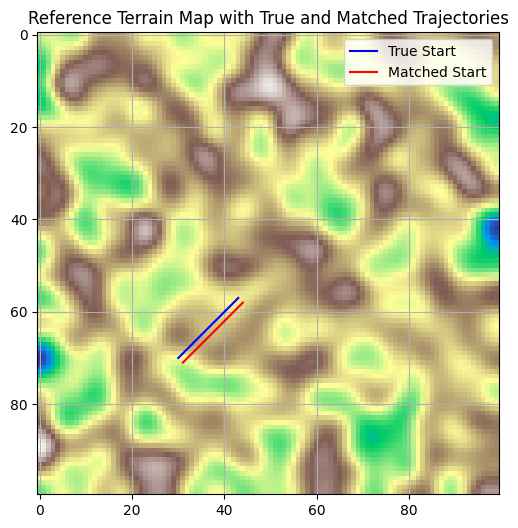

In [67]:
# Visualization
plt.figure(figsize=(6, 6))
plt.title("Reference Terrain Map with True and Matched Trajectories")
plt.imshow(terrain_map, cmap='terrain')
plt.plot(true_profile[0, :], true_profile[1, :], color='blue', label='True Start')
plt.plot(estimated_coords[0, :], estimated_coords[1, :], color='red', label='Matched Start')
plt.legend()
plt.grid(True)
plt.show()

# Evaluation
# rmse_traj = compute_rmse((true_start_x, true_start_y), estimated_coords)
# print(f"Trajectory Matching RMSE: {rmse_traj:.2f} pixels")


### 用法二：航向不断变换

In [96]:
# Simulate terrain map and trajectory-based profile
np.random.seed(42)
terrain_map = gaussian_filter(np.random.rand(100, 100), sigma=3)
true_start_x, true_start_y = 30, 70
true_heading = 45
trajectory_length = 20

matcher_traj = TrajectoryBasedTerrainMatcher(reference_map=terrain_map, window_length=trajectory_length)
true_profile = matcher_traj.gen_multi_trajectory_patch(true_start_x, true_start_y, true_heading, mode=2)

# 用法三:
measured_profile = deepcopy(true_profile)
measured_profile[2, :] = measured_profile[2, :] + np.random.normal(0, 0.01, measured_profile.shape[1])
estimated_coords = matcher_traj.match_trajectory(measured_profile, true_heading, gen_mode=2)

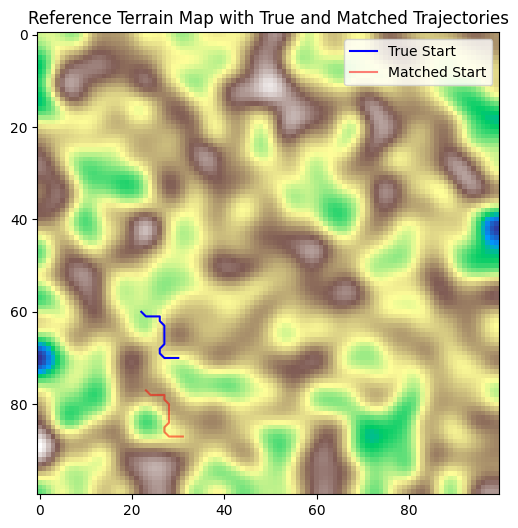

In [97]:
# Visualization
plt.figure(figsize=(6, 6))
plt.title("Reference Terrain Map with True and Matched Trajectories")
plt.imshow(terrain_map, cmap='terrain')
plt.plot(true_profile[0, :], true_profile[1, :], color='blue', label='True Start')
plt.plot(estimated_coords[0, :], estimated_coords[1, :], color='red', label='Matched Start', alpha=0.5)
plt.legend()
#plt.grid(True)
plt.show()

# Evaluation
# rmse_traj = compute_rmse((true_start_x, true_start_y), estimated_coords)
# print(f"Trajectory Matching RMSE: {rmse_traj:.2f} pixels")